## Exercício

Realize uma classificação usando o classificador de arvore de decisão, o dataset do titanic para prever se a pessoa sobreviveu ou não. Imprima a matriz de confusão e verifique se se modelo possui uma boa acurácia e precisão. Em seguida compare com os resultados com uma random forest

## Etapas:

1 - Carregue a base

2 - Explore os dados, verifique se precisam de algum tratamento

3 - Verifique a necessidade de escalonamento

4 - Crie um pipeline e adicione o escalonamento (se necessário) e o estimador

5 - Faça o fit do modelo e verifique as métricas

6 - Replique para os demais estimadores


In [45]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import ConfusionMatrixDisplay, classification_report

In [2]:
titanic = sns.load_dataset('titanic')

titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [3]:
print(titanic.shape)
titanic.info()

(891, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [4]:
titanic.isnull().sum().sort_values(ascending=False).head(10)

deck           688
age            177
embarked         2
embark_town      2
survived         0
pclass           0
sex              0
sibsp            0
parch            0
fare             0
dtype: int64

In [5]:
print(titanic['survived'].value_counts())
print(titanic['alive'].value_counts())

survived
0    549
1    342
Name: count, dtype: int64
alive
no     549
yes    342
Name: count, dtype: int64


In [6]:
print(titanic['pclass'].value_counts())
print(titanic['class'].value_counts())

pclass
3    491
1    216
2    184
Name: count, dtype: int64
class
Third     491
First     216
Second    184
Name: count, dtype: int64


In [7]:
print(titanic['sex'].value_counts())
print(titanic['who'].value_counts())

sex
male      577
female    314
Name: count, dtype: int64
who
man      537
woman    271
child     83
Name: count, dtype: int64


In [8]:
print(titanic['embark_town'].value_counts())
print(titanic['embarked'].value_counts())

embark_town
Southampton    644
Cherbourg      168
Queenstown      77
Name: count, dtype: int64
embarked
S    644
C    168
Q     77
Name: count, dtype: int64


In [9]:
# Algumas colunas contém informação repetida em número e string (survived == alive, pclass == class, embark_town == embarked)
# Exclusão de colunas com muitos dados faltantes ('deck', 'age')
titanic_filtered = titanic.drop(columns=['alive', 'class', 'embark_town', 'deck', 'age'], axis=1)

# Exclusão de dados faltantes <5% do dataset:
titanic_filtered = titanic_filtered.dropna(subset=['embarked'])

titanic_filtered.head()

,survived,pclass,sex,sibsp,parch,fare,embarked,who,adult_male,alone
0,0,3,male,1,0,7.2500,S,man,True,False
1,1,1,female,1,0,71.2833,C,woman,False,False
2,1,3,female,0,0,7.9250,S,woman,False,True
3,1,1,female,1,0,53.1000,S,woman,False,False
4,0,3,male,0,0,8.0500,S,man,True,True


In [10]:
titanic_filtered.isnull().sum()

survived      0
pclass        0
sex           0
sibsp         0
parch         0
fare          0
embarked      0
who           0
adult_male    0
alone         0
dtype: int64

<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


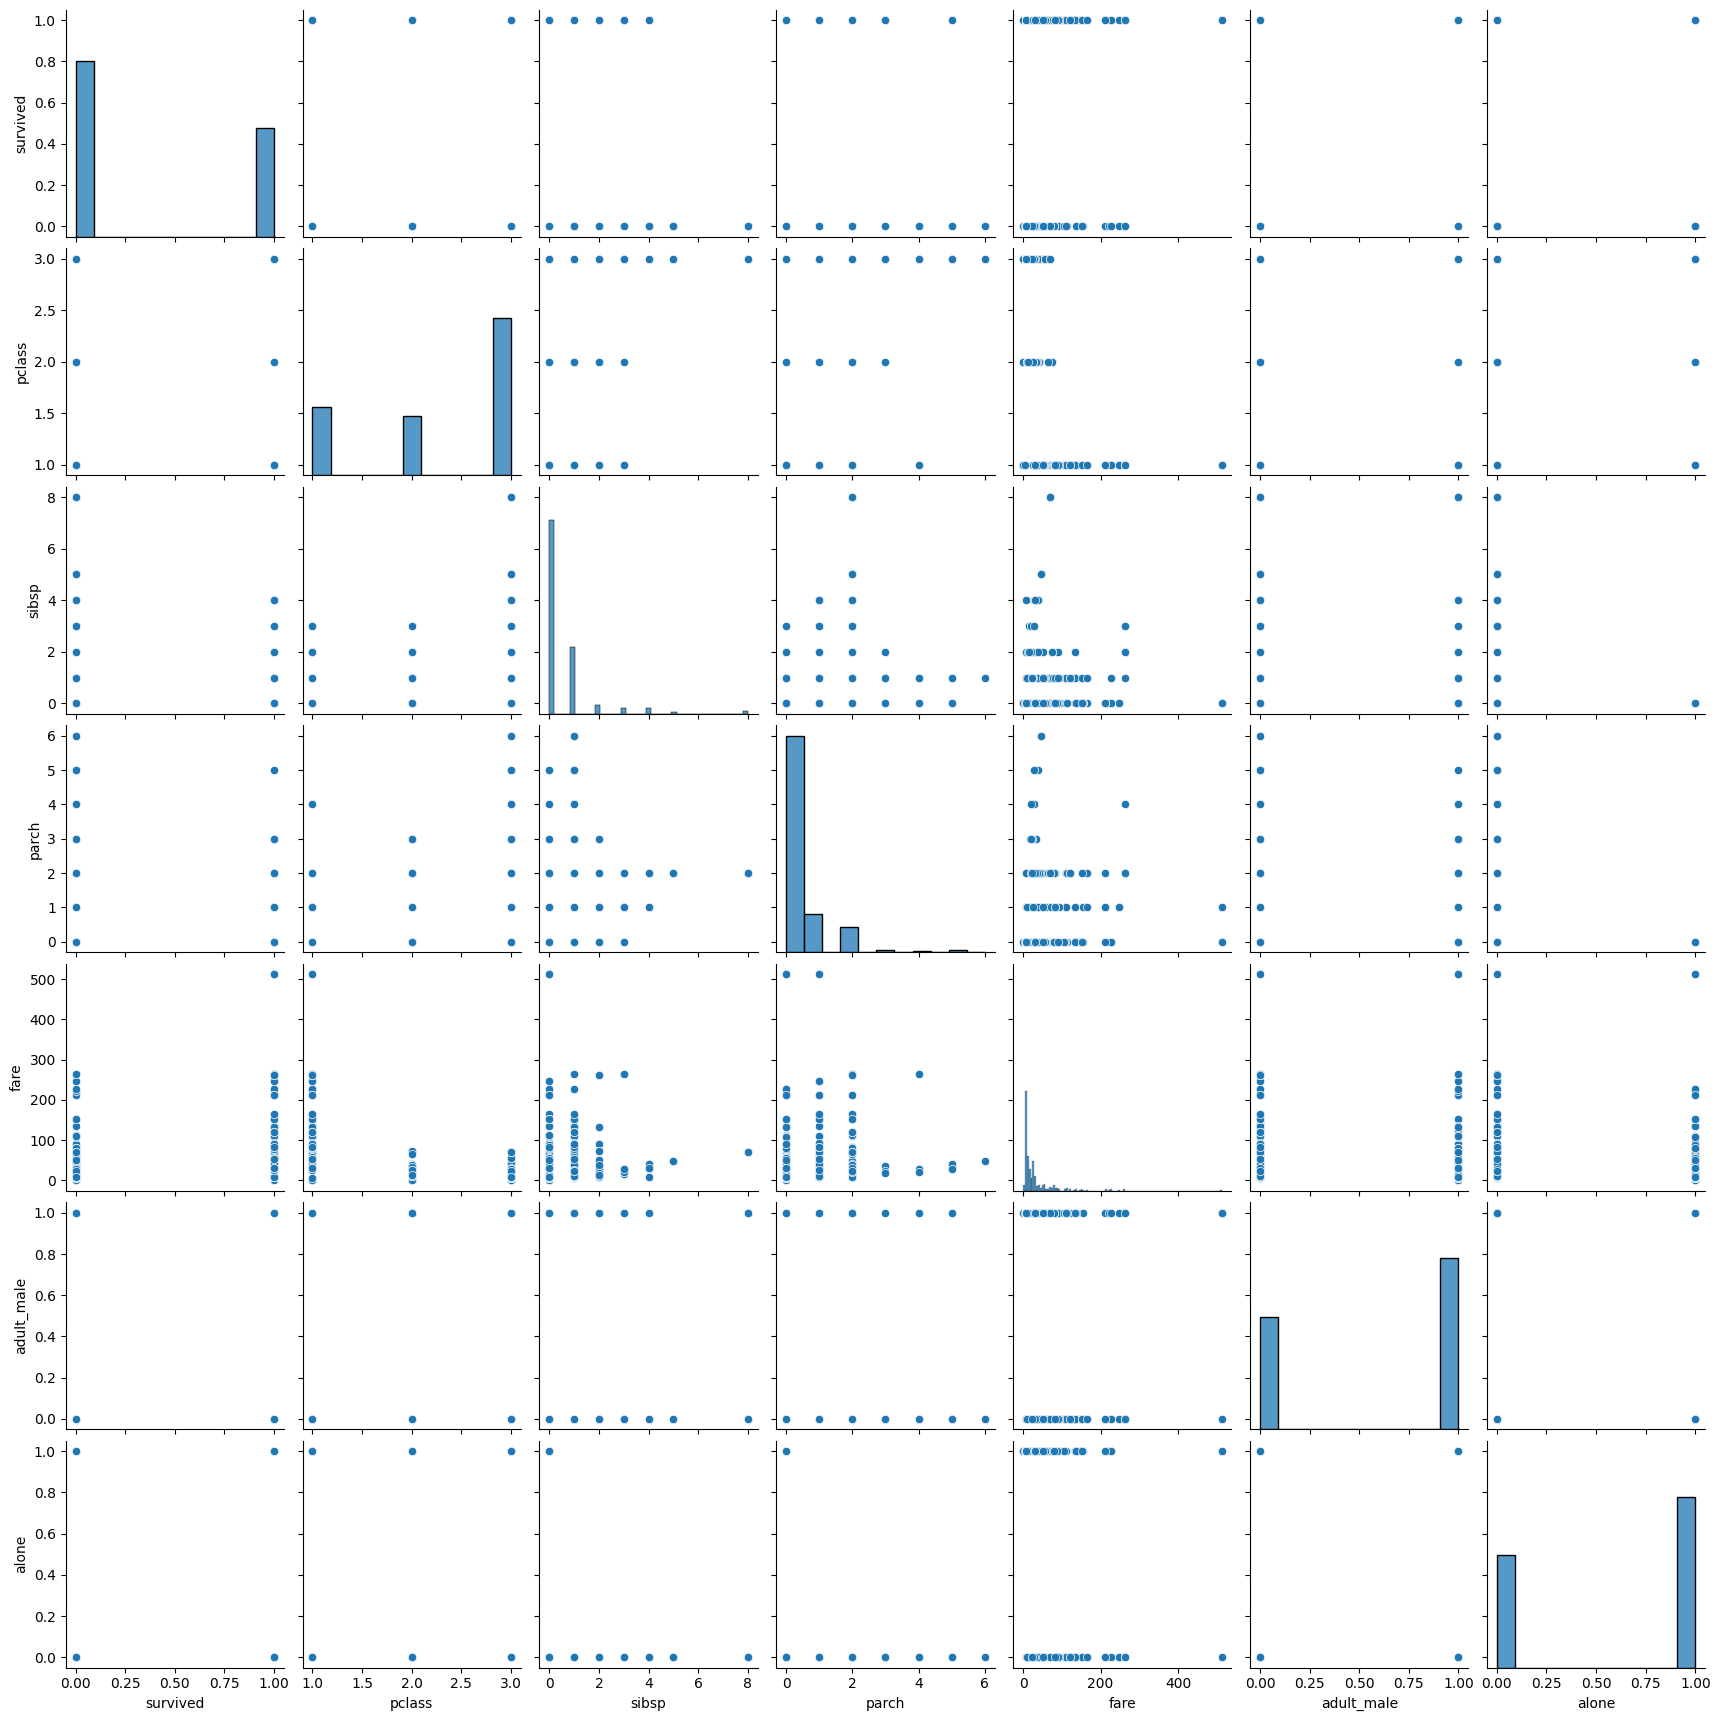

In [60]:
sns.pairplot(titanic_filtered)

<Axes: >

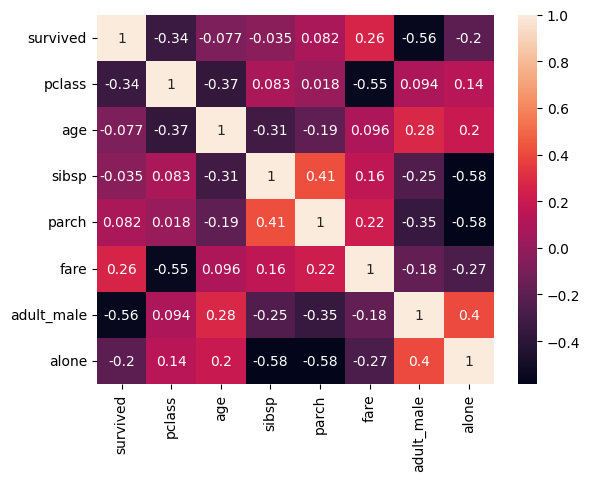

In [ ]:
sns.heatmap(titanic.corr(numeric_only=True), annot=True)

In [22]:
titanic_dummies = pd.get_dummies(titanic_filtered, columns=['sex', 'adult_male', 'alone'], dtype=int, drop_first=True)
titanic_dummies = pd.get_dummies(titanic_dummies, columns=['embarked', 'who'], dtype=int)
titanic_dummies.head()

,survived,pclass,sibsp,parch,fare,sex_male,adult_male_True,alone_True,embarked_C,embarked_Q,embarked_S,who_child,who_man,who_woman
0,0,3,1,0,7.2500,1,1,0,0,0,1,0,1,0
1,1,1,1,0,71.2833,0,0,0,1,0,0,0,0,1
2,1,3,0,0,7.9250,0,0,1,0,0,1,0,0,1
3,1,1,1,0,53.1000,0,0,0,0,0,1,0,0,1
4,0,3,0,0,8.0500,1,1,1,0,0,1,0,1,0


In [23]:
X = titanic_dummies.drop('survived', axis=1)
y = titanic_dummies['survived']


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [29]:
# Decision Tree classifier
steps = [('rb_scaler', RobustScaler()),
         ('dec_tree', DecisionTreeClassifier(random_state=42))]

pipe_dectree = Pipeline(steps)

param_grid = {'dec_tree__criterion': ['gini', 'entropy', 'log_loss'],
              'dec_tree__splitter': ['best', 'random'],
              'dec_tree__max_depth': range(1,11)}

grid_dectree = GridSearchCV(estimator=pipe_dectree,
                            param_grid=param_grid,
                            cv=5,
                            scoring='f1',
                            n_jobs=-1)

grid_dectree.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('rb_scaler', RobustScaler()),
                                       ('dec_tree',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'dec_tree__criterion': ['gini', 'entropy', 'log_loss'],
                         'dec_tree__max_depth': range(1, 11),
                         'dec_tree__splitter': ['best', 'random']},
             scoring='f1')

In [30]:
print(grid_dectree.best_params_)
print(grid_dectree.best_score_)

{'dec_tree__criterion': 'gini', 'dec_tree__max_depth': 6, 'dec_tree__splitter': 'random'}
0.773612796878557


In [37]:
y_pred_train_dt = grid_dectree.predict(X_train)
y_pred_test_dt = grid_dectree.predict(X_test)

print('Classification Report - Treino')
print(classification_report(y_train, y_pred_train))
print('\nClassification Report - Test')
print(classification_report(y_test, y_pred_test))

Classification Report - Treino
              precision    recall  f1-score   support

           0       0.85      0.90      0.87       439
           1       0.82      0.74      0.78       272

    accuracy                           0.84       711
   macro avg       0.83      0.82      0.83       711
weighted avg       0.84      0.84      0.84       711


Classification Report - Test
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       110
           1       0.81      0.68      0.74        68

    accuracy                           0.81       178
   macro avg       0.81      0.79      0.80       178
weighted avg       0.81      0.81      0.81       178



Dados de treino


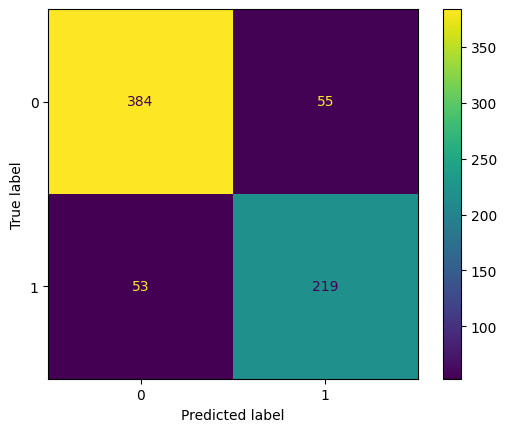


Dados de teste


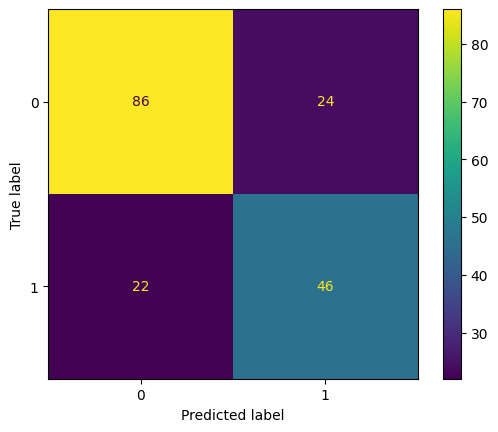

In [46]:
print('Dados de treino')
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train_dt)
plt.show()

print('\nDados de teste')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_dt)
plt.show()

In [33]:
# Random Forest classifier
steps = [('rb_scaler', RobustScaler()),
         ('rf', RandomForestClassifier(random_state=42))]

pipe_rf = Pipeline(steps)

param_grid = {'rf__n_estimators': range(50, 500, 50),
              'rf__criterion': ['gini', 'entropy', 'log_loss'],
              'rf__max_depth': range(1,11)}

grid_rf = GridSearchCV(estimator=pipe_rf,
                            param_grid=param_grid,
                            cv=5,
                            scoring='f1',
                            n_jobs=-1)

grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('rb_scaler', RobustScaler()),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__criterion': ['gini', 'entropy', 'log_loss'],
                         'rf__max_depth': range(1, 11),
                         'rf__n_estimators': range(50, 500, 50)},
             scoring='f1')

In [48]:
print(grid_rf.best_params_)
print(grid_rf.best_score_)

{'rf__criterion': 'gini', 'rf__max_depth': 5, 'rf__n_estimators': 250}
0.7686328661622452


In [36]:
# Random Forest Classification Report
y_pred_train_rf = grid_rf.predict(X_train)
y_pred_test_rf = grid_rf.predict(X_test)

print('Classification Report - Treino')
print(classification_report(y_train, y_pred_train))
print('\nClassification Report - Test')
print(classification_report(y_test, y_pred_test))

Classification Report - Treino
              precision    recall  f1-score   support

           0       0.85      0.90      0.87       439
           1       0.82      0.74      0.78       272

    accuracy                           0.84       711
   macro avg       0.83      0.82      0.83       711
weighted avg       0.84      0.84      0.84       711


Classification Report - Test
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       110
           1       0.81      0.68      0.74        68

    accuracy                           0.81       178
   macro avg       0.81      0.79      0.80       178
weighted avg       0.81      0.81      0.81       178



Dados de treino


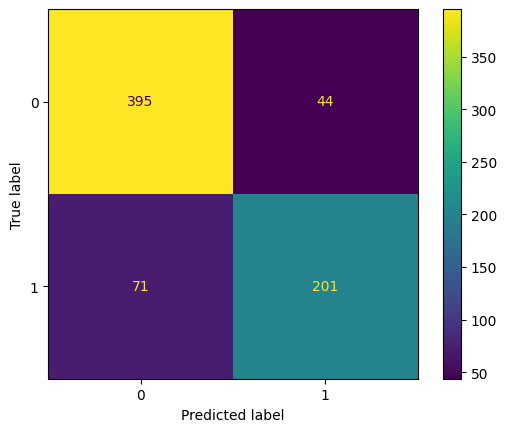


Dados de teste


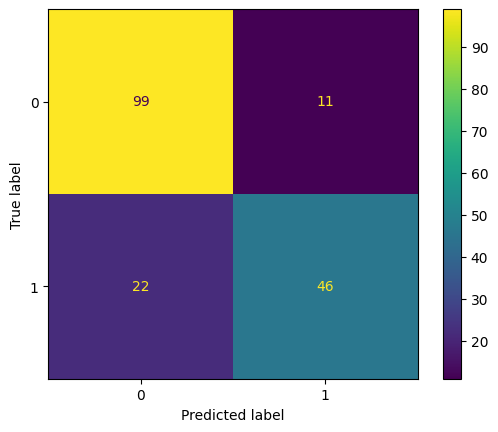

In [47]:
print('Dados de treino')
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train_rf)
plt.show()

print('\nDados de teste')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_rf)
plt.show()

O resultado da Random Forest foi um pouco melhor na predição dos true negative e apresentou valores de métricas mais próximos entre treino e teste.